C:\Users\manur\AppData\Local\Temp\ipykernel_19632\397161596.py:110: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_19632\397161596.py:110: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_19632\397161596.py:110: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_19632\397161596.py:110: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_19632\397161596.py:110: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_19632\397161596.py:110: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_19632\397161596.py:110: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_19632\397161596.py:110: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_19632\397161596.py:110: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_19

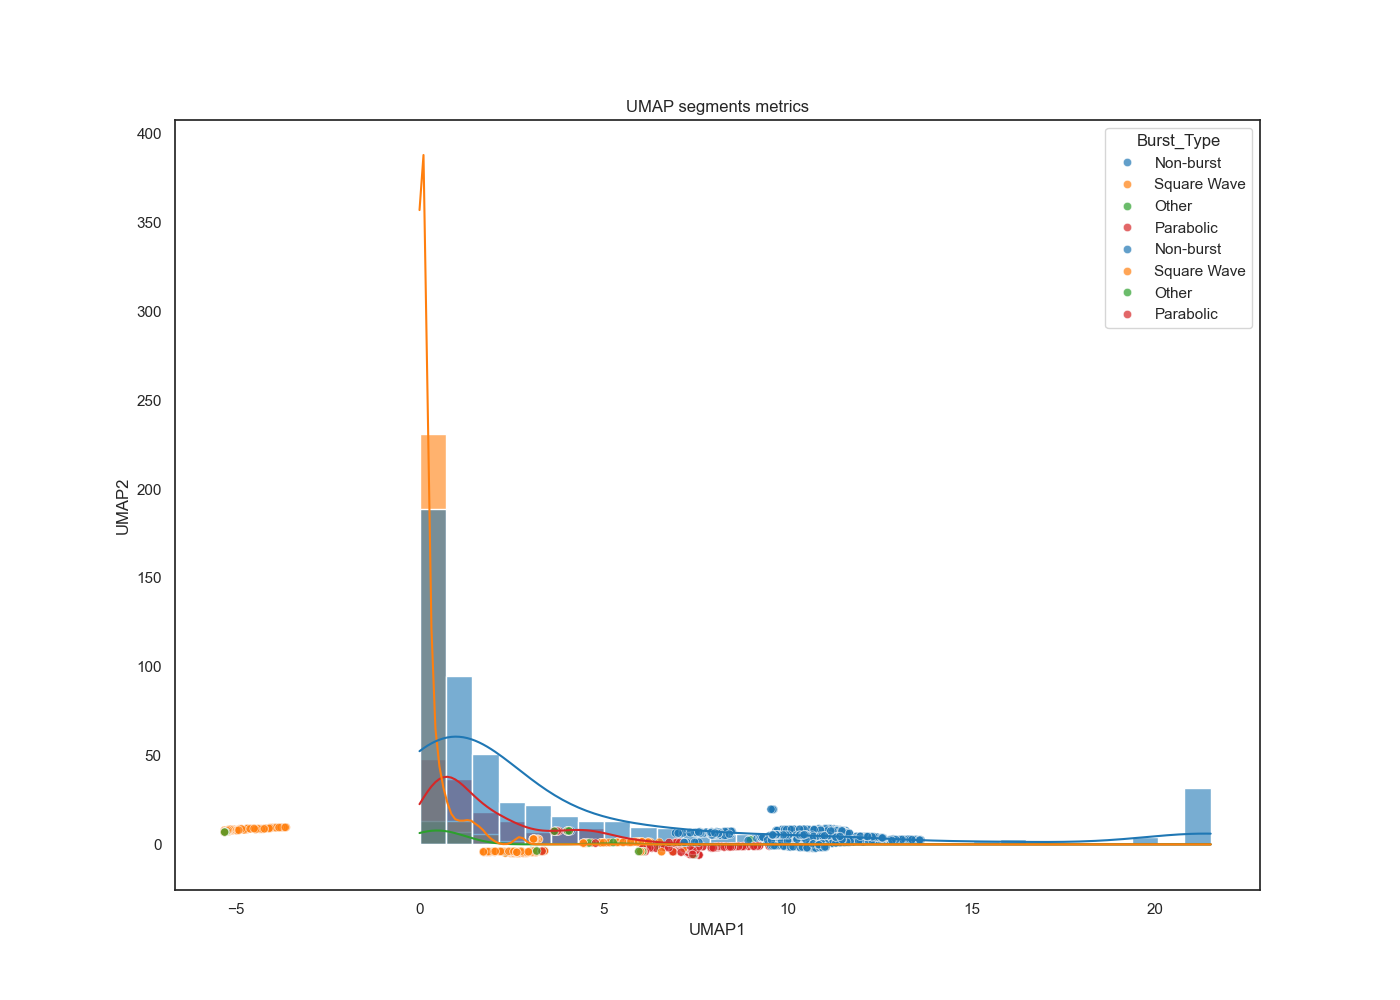

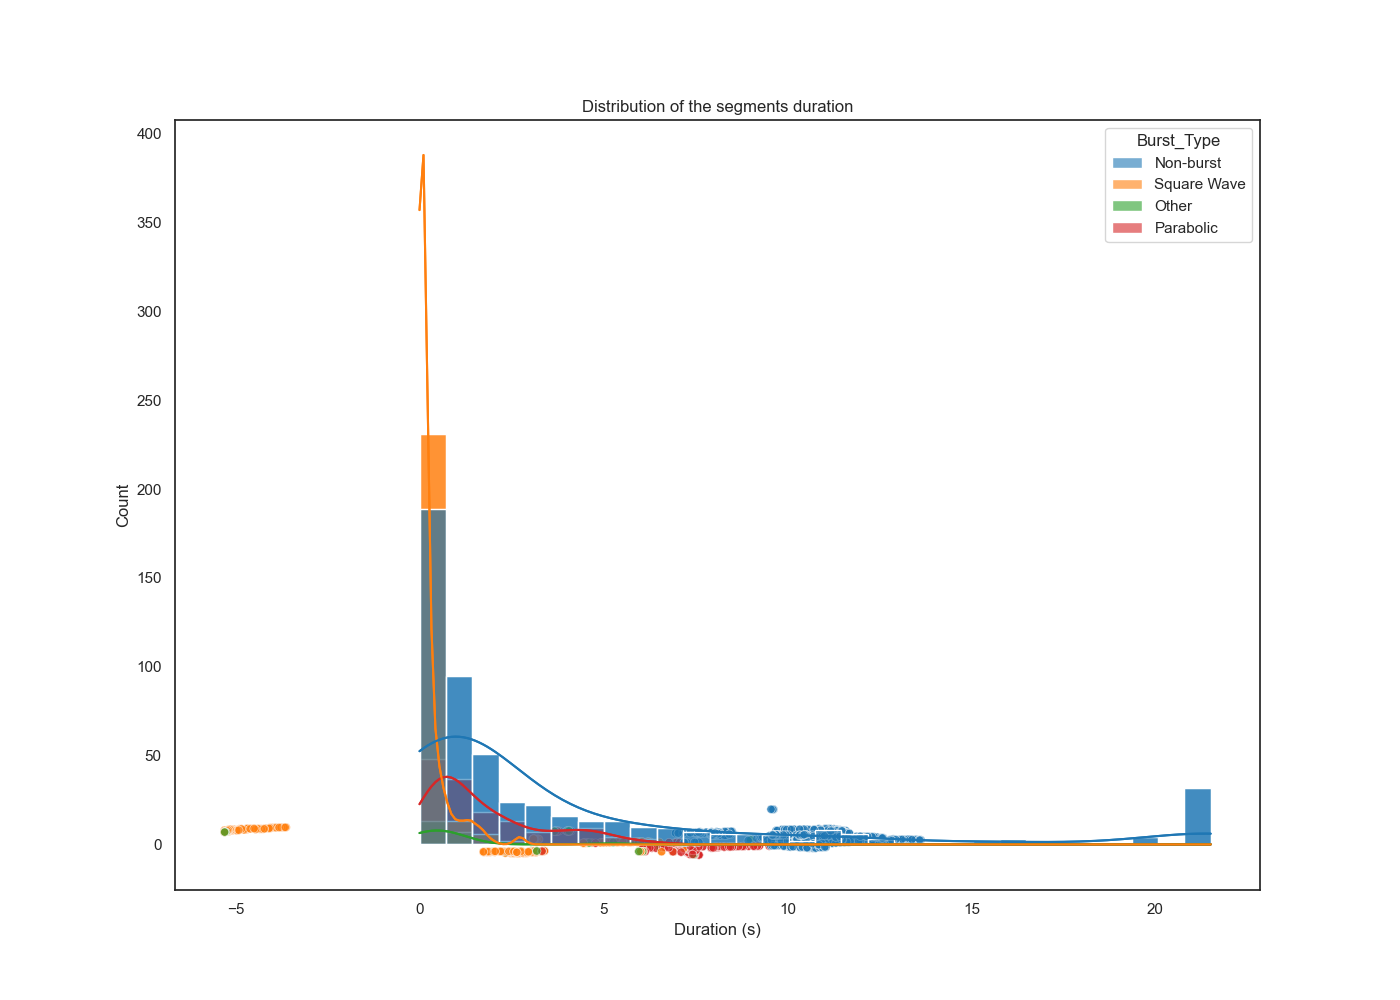

In [2]:
#Load libraries
import os
import pyabf                       # To read ABF (Axon Binary Format) electrophysiology files
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks, hilbert
from numpy.linalg import lstsq
from sklearn.metrics import r2_score
%matplotlib widget

#Dimensionality reduction & ML
import umap
from sklearn.preprocessing import StandardScaler

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"

#Parameters
folder_path = "bursting"   # Folder containing ABF files
threshold = -35            # Voltage threshold (mV) for spike detection
burst_threshold = 0.3      # Maximum inter-spike interval (ISI) to be considered in same burst (s)
fs = 10000                 # Sampling frequency in Hz
dt = 1 / fs                # Time step

#Criteria for burst classification
min_spikes_in_burst = 4    # A burst must contain at least 4 spikes (best value in range 3–6)
max_isi = 0.3              # Maximum ISI allowed inside burst
min_spike_rate = 5         # Minimum spike rate (Hz)

all_segment_metrics = []   # Store computed metrics for all segments

#Collect ABF files
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

#Loop over each ABF file and sweep
for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)

    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX          # Time vector
        voltage = abf.sweepY       # Voltage trace

        #Spike detection
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs   # Spike times in seconds

        #Burst detection
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)     # Inter-spike intervals
            current_burst = [spike_times[0]]

            for i in range(1, len(spike_times)):
                if isi[i-1] < burst_threshold:       # If ISI is small → continue burst
                    current_burst.append(spike_times[i])
                else:                                # If ISI too long → end current burst
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]
            # Save last burst if valid
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))

        #Define segments (bursts and non-bursts)
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        if bursts:
            # Pre-burst segment
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            # Between bursts
            for i in range(len(bursts)-1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            # Post-burst segment
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            segments.append((time[0], time[-1], "Non-burst"))

        # Classify bursts into types
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]
                seg_time = time[seg_mask]

                # Baseline before/after the burst
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])

                # Burst minimum voltage
                burst_min = np.min(seg_voltage)

                #Parabolic fit (least squares quadratic)
                t = np.linspace(-0.5, 0.5, len(seg_voltage))
                X = np.vstack([t**2, t, np.ones_like(t)]).T
                coef, *_ = lstsq(X, seg_voltage, rcond=None)
                y_hat = X @ coef
                r2_parabola = r2_score(seg_voltage, y_hat)

                # Symmetry from Hilbert envelope
                analytic_signal = hilbert(seg_voltage)
                envelope = np.abs(analytic_signal)
                half = len(envelope) // 2
                symmetry = (np.corrcoef(envelope[:half], envelope[-half:][::-1])[0, 1]
                            if half >= 2 else np.nan)

                #Spike metrics inside burst
                seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
                spike_rate = len(seg_peaks) / (seg_end - seg_start)

                #Classification rules
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"

            burst_types.append(burst_type)

        #Compute metrics for each segment
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start
            burst_type = burst_types[j]

            # Spike-based features
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            # Basic statistics on raw signal
            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)

            # Statistics on derivative of signal
            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            # Store all computed features
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])

# Save results to CSV
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurtosis_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)

# Visualization: UMAP & Distributions 
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
df = pd.read_csv("segment_voltage_metrics_with_ISI_and_peaks.csv")

# Features for dimensionality reduction
header = list(df)[4:]   # Ignore metadata columns
X = np.array(df[header])
y = np.array(df.Burst_Type)

# Scale features before UMAP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP embedding (2D)
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Create UMAP dataframe
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y

# Static plots 
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", 
                hue="Burst_Type", palette="tab10", alpha=0.7)
plt.title("UMAP segments metrics")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

sns.set(style="whitegrid", context="notebook", rc={'figure.figsize':(10,6)})
sns.histplot(data=df_segments, x="Duration", hue="Burst_Type",
             bins=30, kde=True, palette="tab10", alpha=0.6)
plt.title("Distribution of the segments duration")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()

# Interactive plot 
fig = px.scatter(df_umap, x="UMAP1", y="UMAP2", color="Burst_Type", title="UMAP")
pio.renderers.default = "browser"
fig.show()


Distance between centroids of burst types:
Burst_Type   Non-burst     Other  Parabolic  Square Wave
Burst_Type                                              
Non-burst     0.000000  6.982493   6.356981     9.964681
Other         6.982493  0.000000   5.053357     2.984769
Parabolic     6.356981  5.053357   0.000000     7.086916
Square Wave   9.964681  2.984769   7.086916     0.000000

Overlap threshold (UMAP distance): 3.192

Potentially overlapping burst type pairs:
[('Other', 'Square Wave')]

Number of segments in conflict regions: 147
Burst_Type
Non-burst      17
Other          21
Parabolic      73
Square Wave    36
dtype: int64


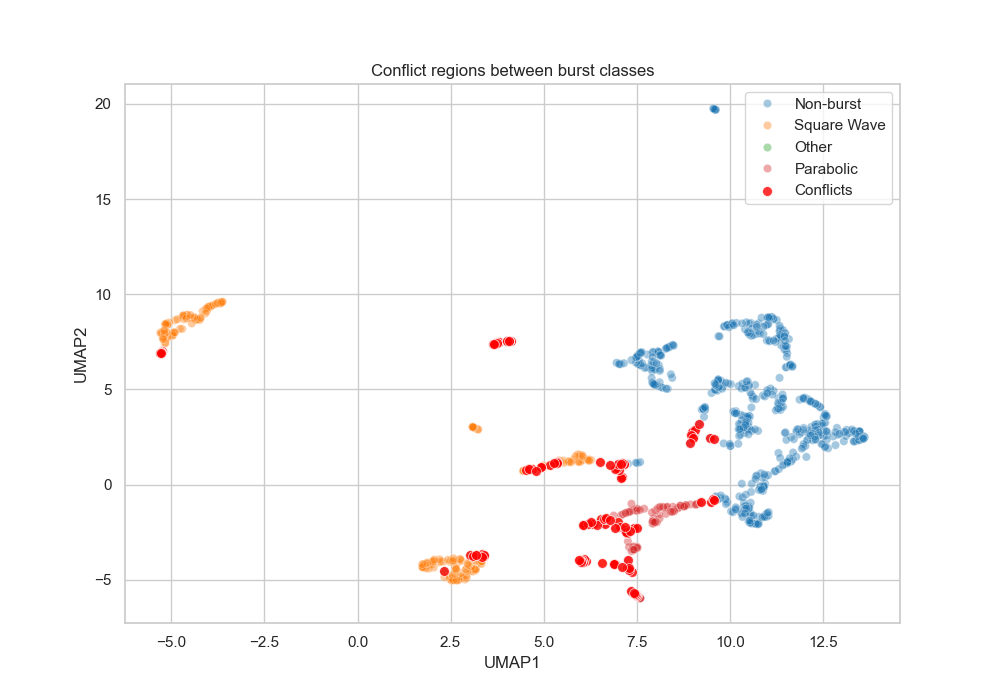

In [4]:
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
%matplotlib widget

# Add index column so we can trace points back to the original df_segments
df_umap["Index"] = df.index  

# 1. Calculate centroids for each burst type 
# For each Burst_Type, compute the mean UMAP1 and UMAP2 coordinates
centroids = df_umap.groupby("Burst_Type")[["UMAP1", "UMAP2"]].mean()

# 2. Compute distance matrix between centroids 
# Pairwise Euclidean distances between cluster centroids
dist_matrix = distance.cdist(centroids.values, centroids.values)
dist_df = pd.DataFrame(dist_matrix, index=centroids.index, columns=centroids.index)

print("\nDistance between centroids of burst types:")
print(dist_df)

# Define an overlap threshold = 10% of the shortest distances (excluding 0)
threshold = np.percentile(dist_matrix[dist_matrix > 0], 10)
print(f"\nOverlap threshold (UMAP distance): {threshold:.3f}")

# Find burst type pairs whose centroids are closer than the threshold
close_pairs = []
for i, type_i in enumerate(centroids.index):
    for j, type_j in enumerate(centroids.index):
        if j > i and dist_matrix[i, j] < threshold:
            close_pairs.append((type_i, type_j))

print("\nPotentially overlapping burst type pairs:")
print(close_pairs)

# 3. Detect individual points in mixed regions 
# Get UMAP coordinates and labels for all points
X_umap = df_umap[["UMAP1", "UMAP2"]].values
labels = df_umap["Burst_Type"].values

# Build nearest-neighbors model (8 neighbors per point)
nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

# Identify points that have neighbors from a different burst type
conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):  # at least one neighbor has a different type
        conflict_indices.append(df_umap.iloc[i]["Index"])

# Retrieve those "conflict points" from the original dataset
conflicts_df = df_segments.iloc[conflict_indices]

print(f"\nNumber of segments in conflict regions: {len(conflicts_df)}")
print(conflicts_df.groupby("Burst_Type").size())

# 4. Plot conflict points on UMAP embedding 
plt.figure(figsize=(10, 7))

# Plot all points colored by burst type (transparent for clarity)
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", 
                hue="Burst_Type", alpha=0.4, palette="tab10")

# Overlay conflict points in red
sns.scatterplot(data=df_umap.iloc[conflict_indices], x="UMAP1", y="UMAP2", 
                color="red", s=50, label="Conflicts", alpha=0.8)

plt.legend()
plt.title("Conflict regions between burst classes")
plt.show()

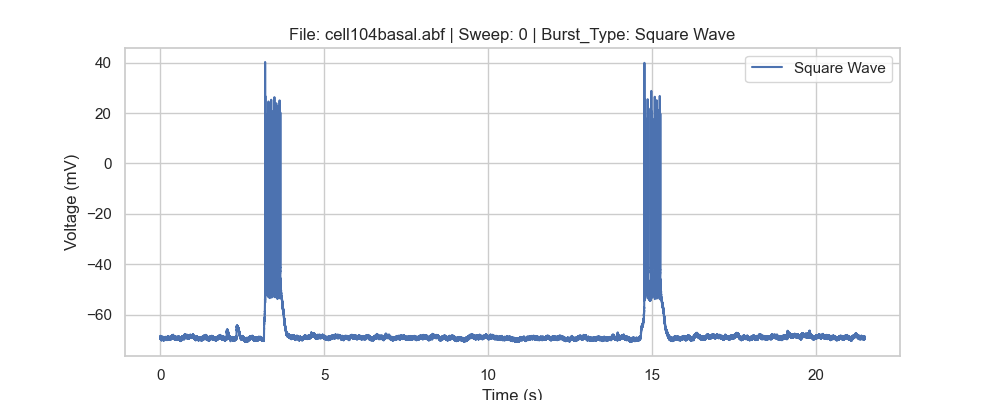

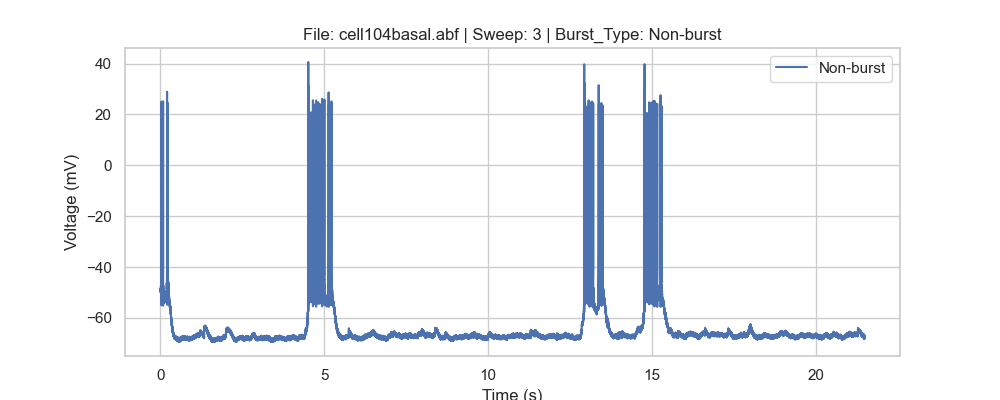

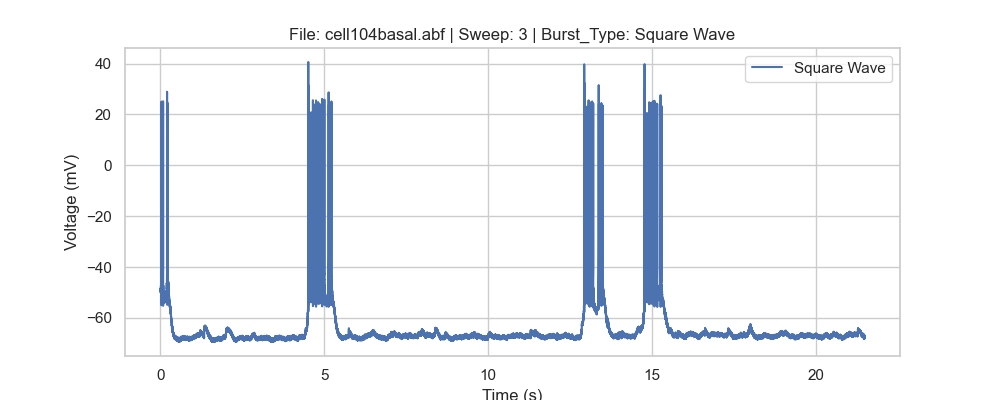

In [5]:
# Example: compare the first 3 conflicting segments
for idx in conflicts_df.head(3).index:      # Loop over the first 3 conflicts
    row = conflicts_df.loc[idx]             # Get the row info for this conflict
    file_path = os.path.join(folder_path, row["File_Name"])
    abf = pyabf.ABF(file_path)              # Load the ABF file again
    abf.setSweep(row["Sweep"])              # Select the correct sweep
    time = abf.sweepX
    voltage = abf.sweepY
    
    # Plot only the sweep that contains the conflict 
    mask = (time >= 0) & (time <= time[-1])  # Full sweep (you could refine to only the segment)
    plt.figure(figsize=(10, 4))
    plt.plot(time[mask], voltage[mask], label=f"{row['Burst_Type']}")
    plt.title(f"File: {row['File_Name']} | Sweep: {row['Sweep']} | Burst_Type: {row['Burst_Type']}")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.legend()
    plt.show()


Potentially overlapping burst type pairs (by centroids):
[('Other', 'Square Wave')]

Number of segments in conflict regions: 147
Burst_Type
Non-burst      17
Other          21
Parabolic      73
Square Wave    36
dtype: int64


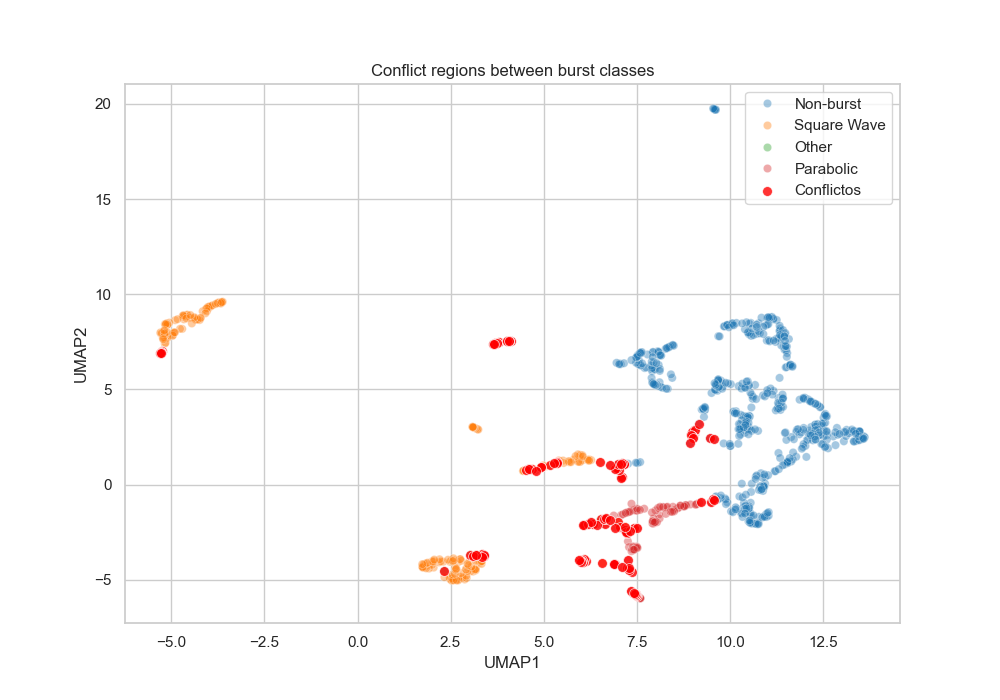

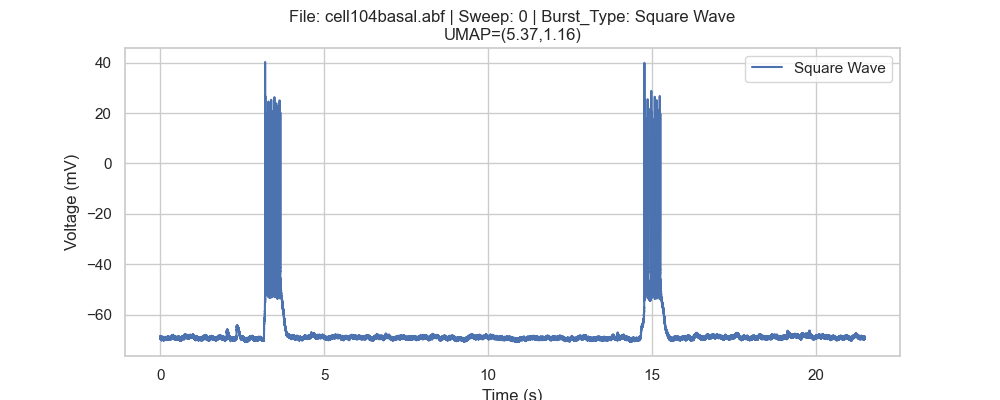

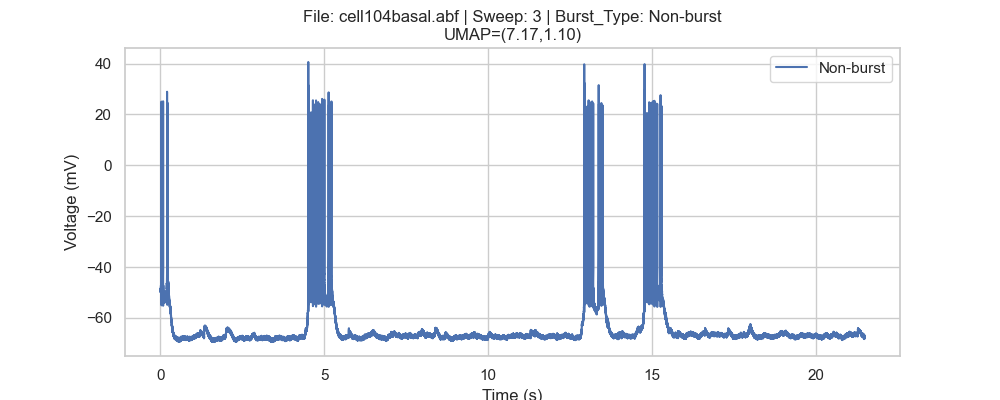

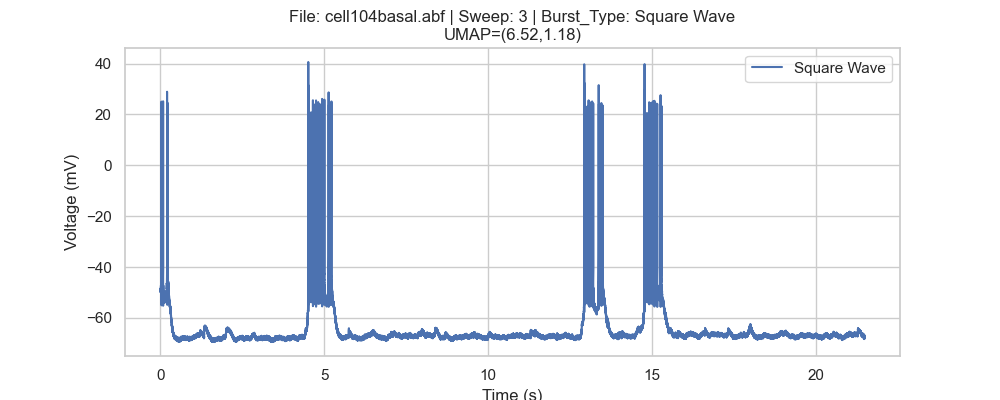


File 'conflict_segments_with_umap.csv' saved with metrics and UMAP coordinates of conflict points.


In [6]:
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

# 1. Add index to link UMAP data with original df_segments
df_umap["Index"] = df.index  # Each UMAP row now has a reference back to df_segments

# 2. Compute centroids for each burst type
centroids = df_umap.groupby("Burst_Type")[["UMAP1", "UMAP2"]].mean()
dist_matrix = distance.cdist(centroids.values, centroids.values) # Distance matrix between all centroids
threshold = np.percentile(dist_matrix[dist_matrix > 0], 10)  # Threshold = 10% of the shortest nonzero centroid-to-centroid distances

# Find burst type pairs whose centroids are closer than the threshold
close_pairs = []
for i, type_i in enumerate(centroids.index):
    for j, type_j in enumerate(centroids.index):
        if j > i and dist_matrix[i, j] < threshold:
            close_pairs.append((type_i, type_j))

print("\nPotentially overlapping burst type pairs (by centroids):")
print(close_pairs)

# 3. Detect conflicting points using nearest neighbors
X_umap = df_umap[["UMAP1", "UMAP2"]].values
labels = df_umap["Burst_Type"].values

# Build nearest neighbors model (8 neighbors per point)
nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

# Mark points that have neighbors of a different class
conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):  # if at least one neighbor differs
        conflict_indices.append(df_umap.iloc[i]["Index"])

# Extract metrics (from df_segments) and UMAP coords for the conflicts
conflicts_df = df_segments.iloc[conflict_indices]
conflict_umap_coords = df_umap.iloc[conflict_indices][["UMAP1", "UMAP2", "Burst_Type"]]

# FIX: remove duplicate column before joining
conflict_umap_coords_nodup = conflict_umap_coords.drop(columns=["Burst_Type"])
conflict_data = conflicts_df.copy()
conflict_data = conflict_data.join(conflict_umap_coords_nodup.set_index(conflict_data.index))

print(f"\nNumber of segments in conflict regions: {len(conflict_data)}")
print(conflict_data.groupby("Burst_Type").size())

# 4. Plot UMAP with conflicts highlighted 
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Burst_Type", alpha=0.4, palette="tab10")
sns.scatterplot(data=conflict_umap_coords, x="UMAP1", y="UMAP2",
                color="red", s=50, label="Conflictos", alpha=0.8)
plt.legend()
plt.title("Conflict regions between burst classes")
plt.show()

# 5. Plot time-series for the first N conflicts 

N = 3  # number of conflicts to plot
for idx in conflict_data.head(N).index:
    row = conflict_data.loc[idx]
    file_path = os.path.join(folder_path, row["File_Name"])
    abf = pyabf.ABF(file_path)
    abf.setSweep(row["Sweep"])
    time = abf.sweepX
    voltage = abf.sweepY

    # Plot only the sweep (you could refine this to segment start/end)
    seg_start = time.min()
    seg_end = time.max()
    mask = (time >= seg_start) & (time <= seg_end)

    plt.figure(figsize=(10, 4))
    plt.plot(time[mask], voltage[mask], label=f"{row['Burst_Type']}")
    plt.title(f"File: {row['File_Name']} | Sweep: {row['Sweep']} | Burst_Type: {row['Burst_Type']}\nUMAP=({row['UMAP1']:.2f},{row['UMAP2']:.2f})")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.legend()
    plt.show()

# 6. Save conflict results for later inspection 
conflict_data.to_csv("conflict_segments_with_umap.csv", index=False)
print("\nFile 'conflict_segments_with_umap.csv' saved with metrics and UMAP coordinates of conflict points.")

C:\Users\manur\AppData\Local\Temp\ipykernel_19632\4088114410.py:91: RuntimeWarning:

Mean of empty slice

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



CSV saved with 951 segments and UMAP coordinates.
158 segments are in conflict regions.
231 conflict pairs detected.


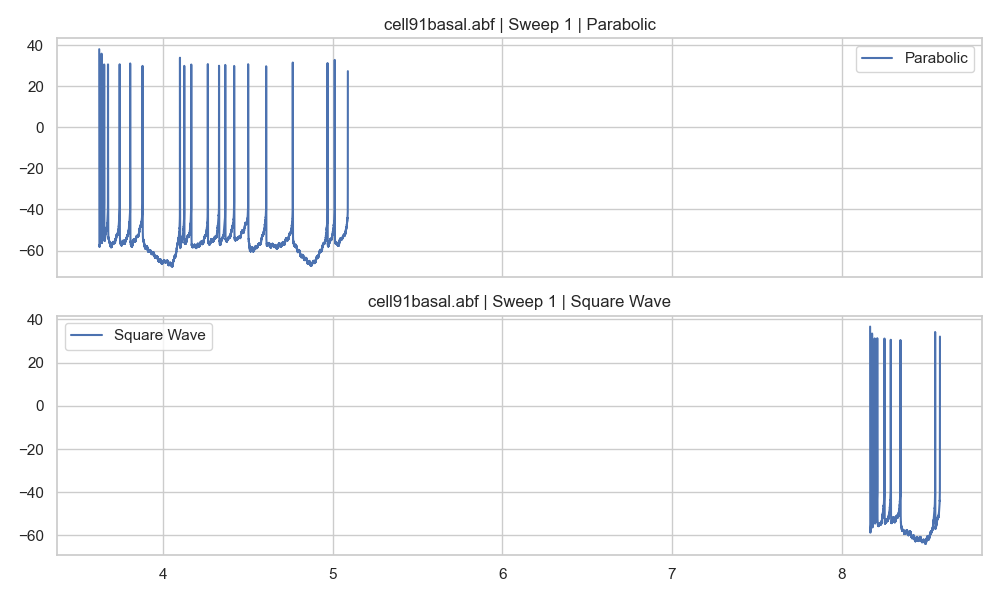

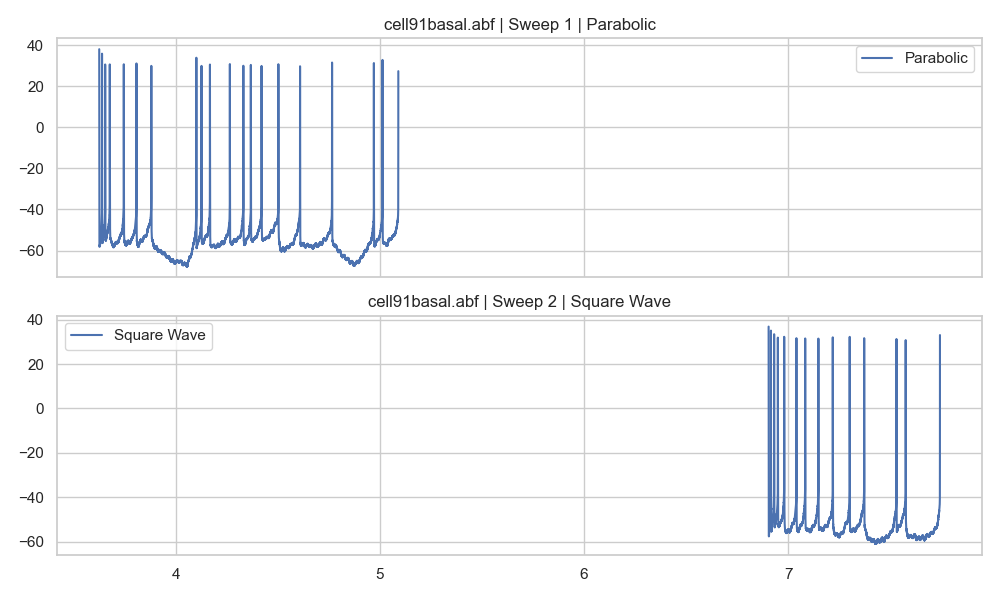

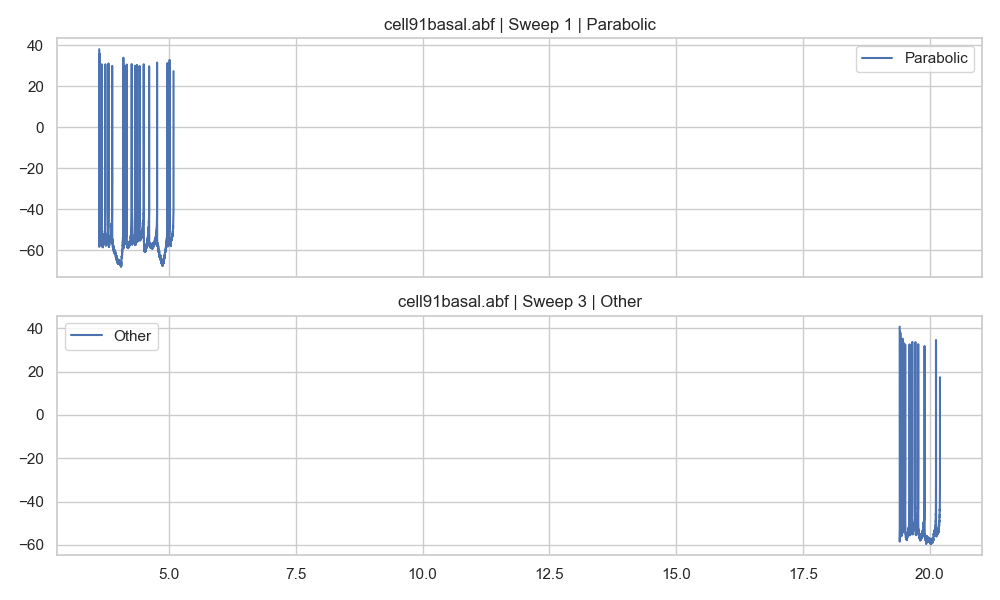

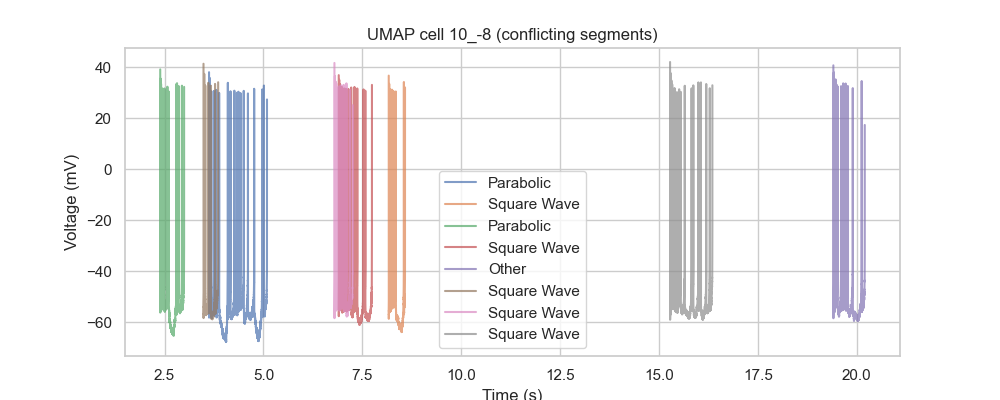

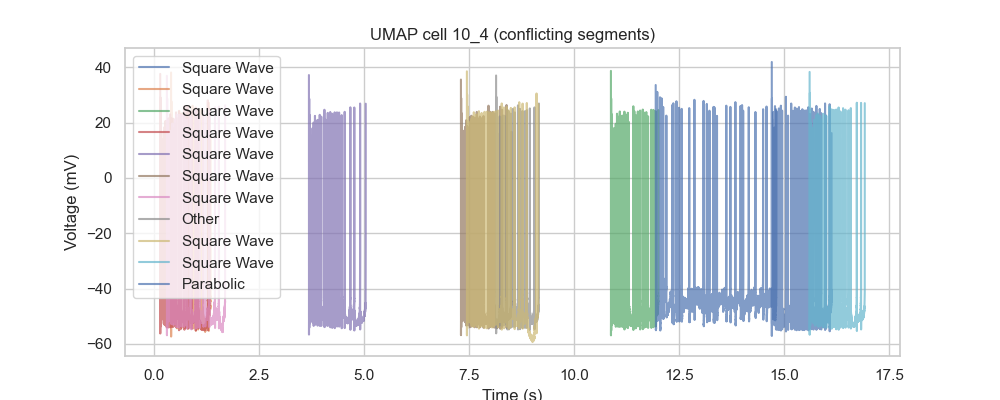

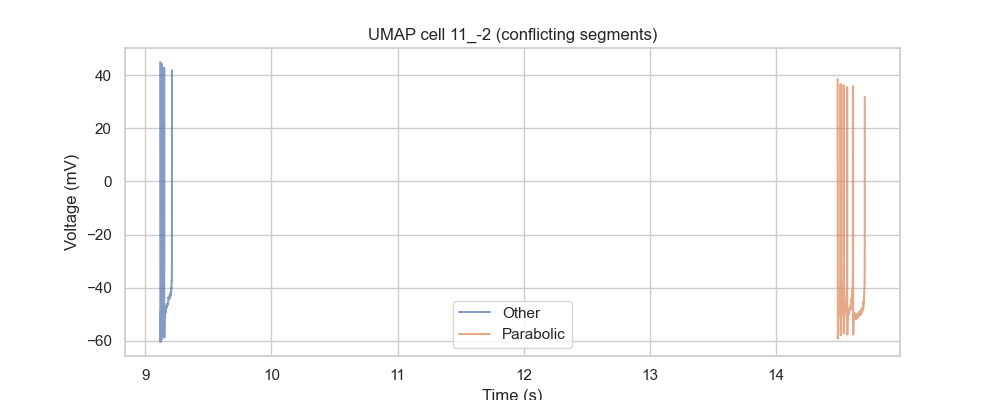

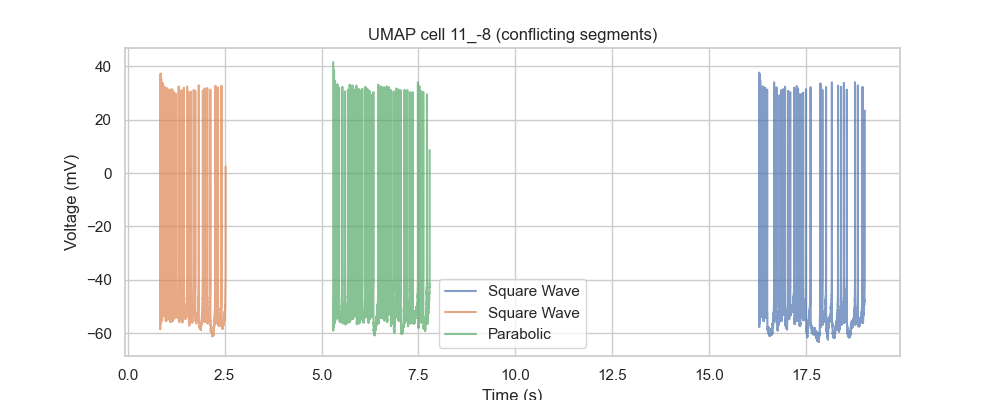

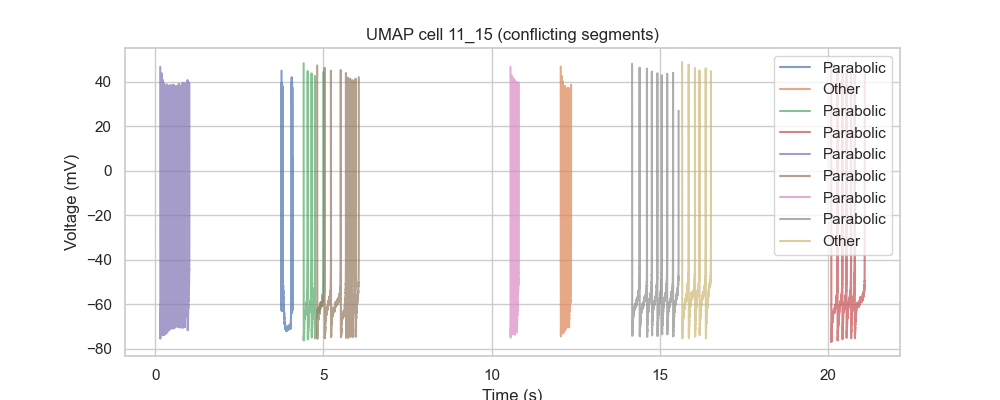

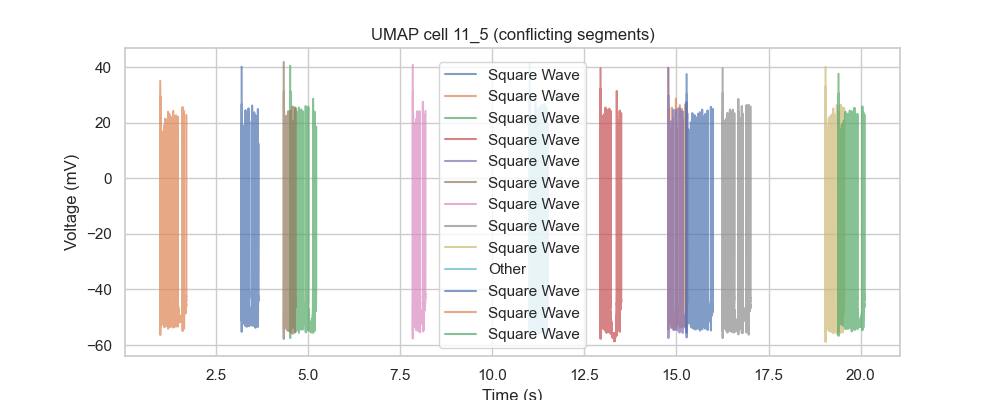

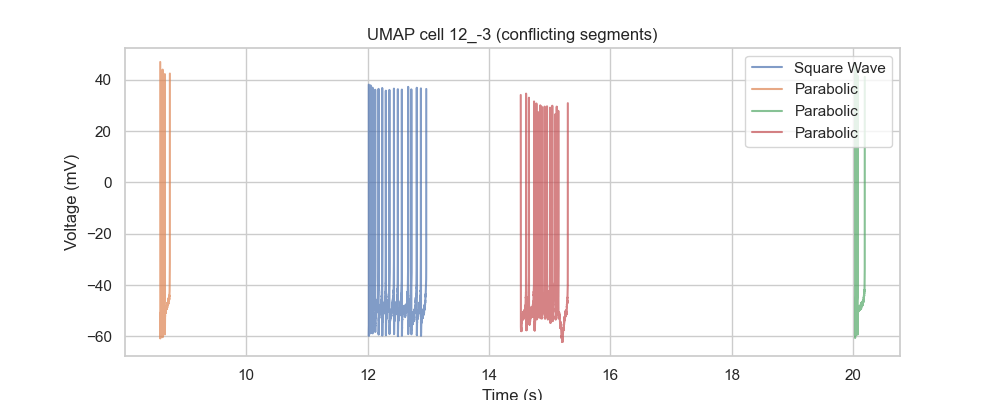

C:\Users\manur\AppData\Local\Temp\ipykernel_19632\4088114410.py:219: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



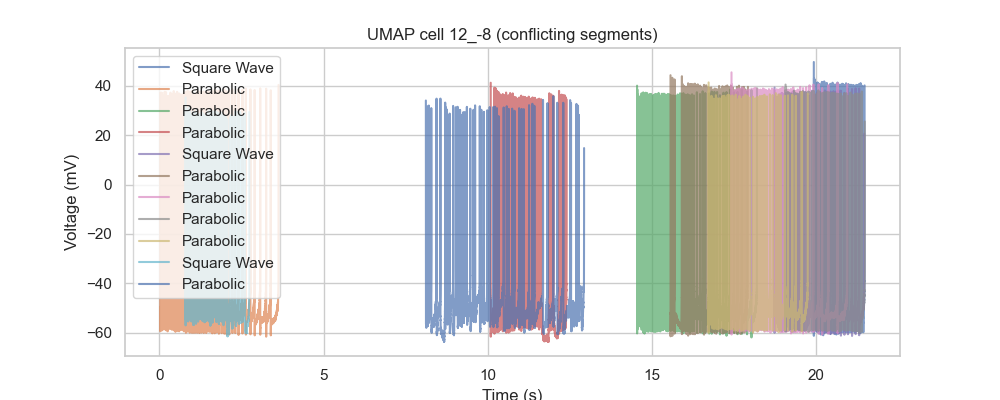

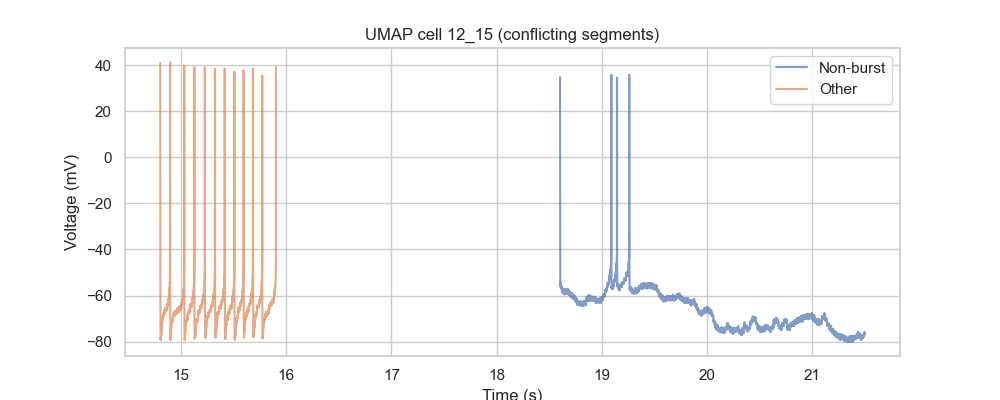

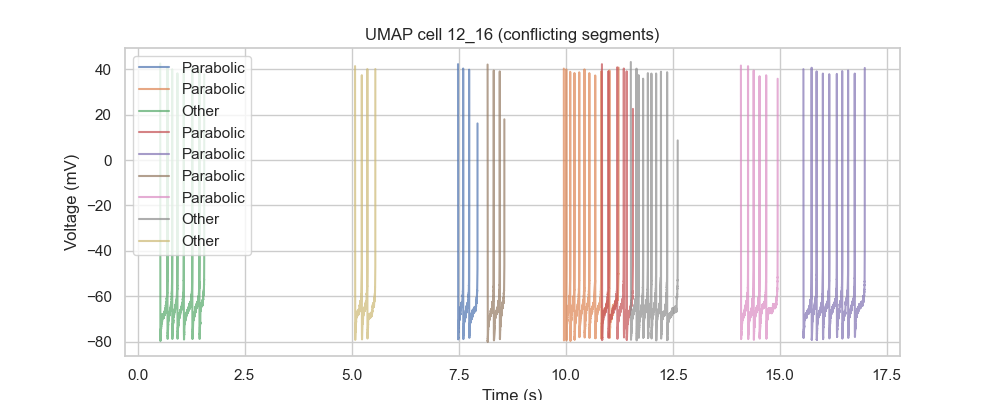

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



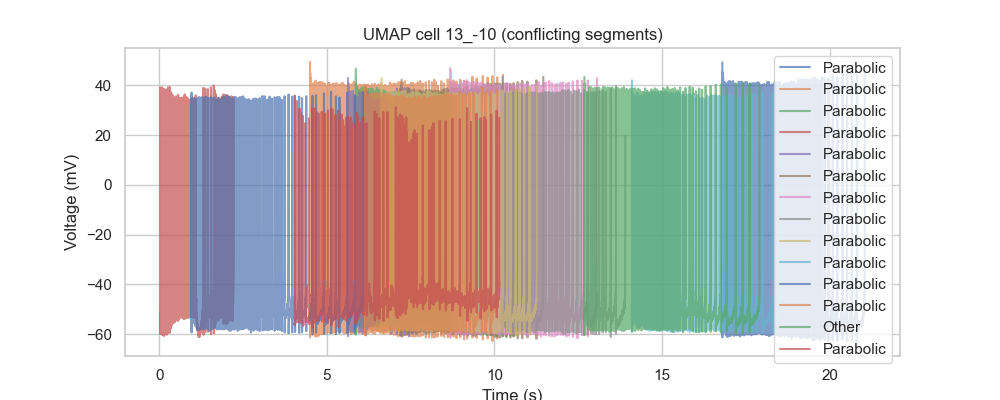

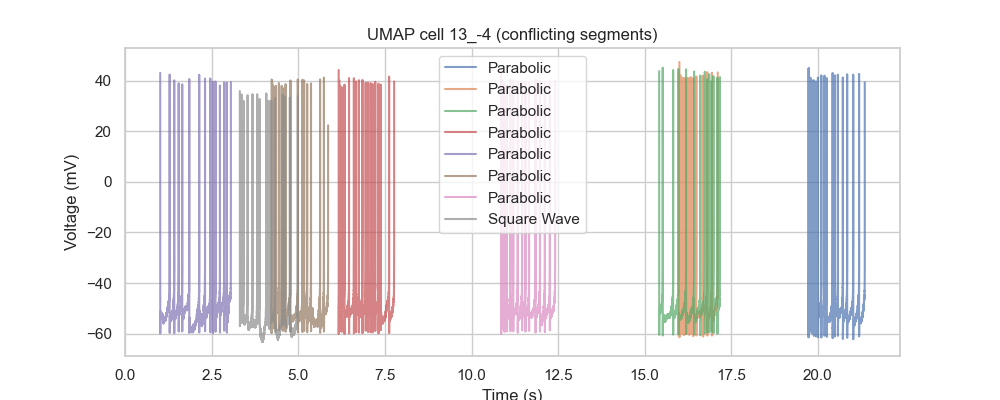

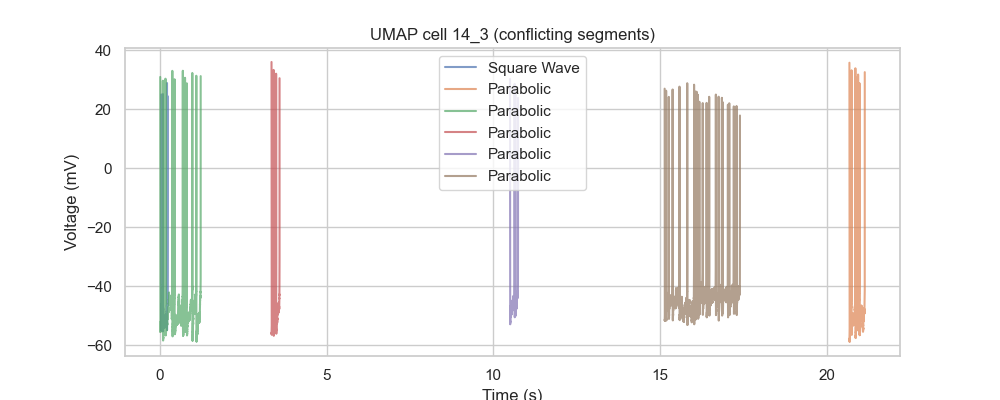

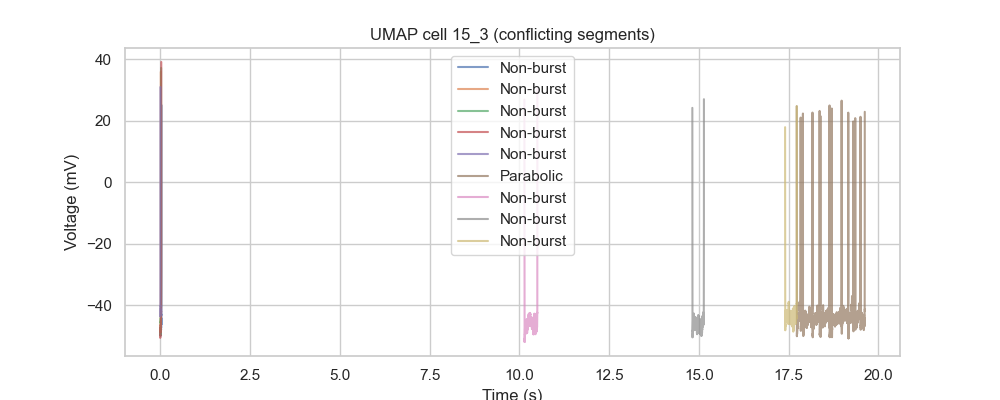

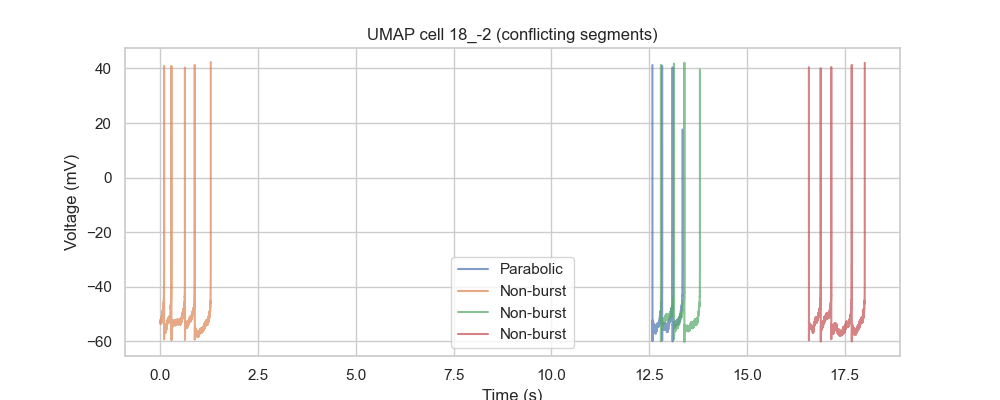

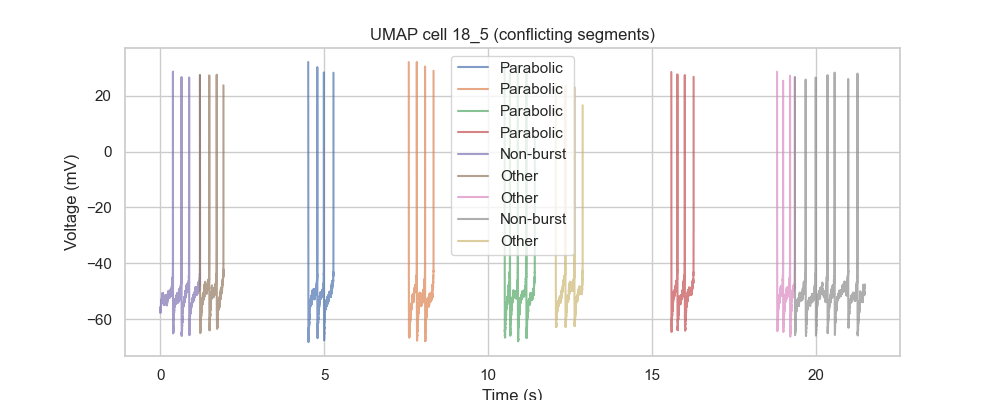

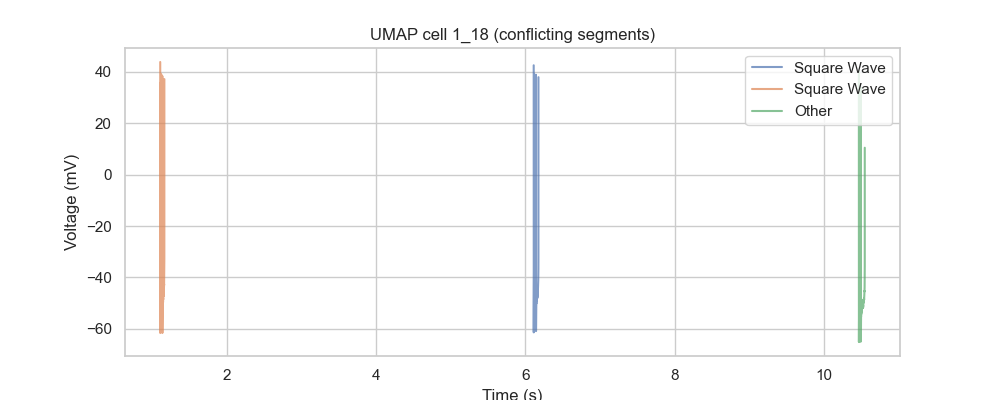

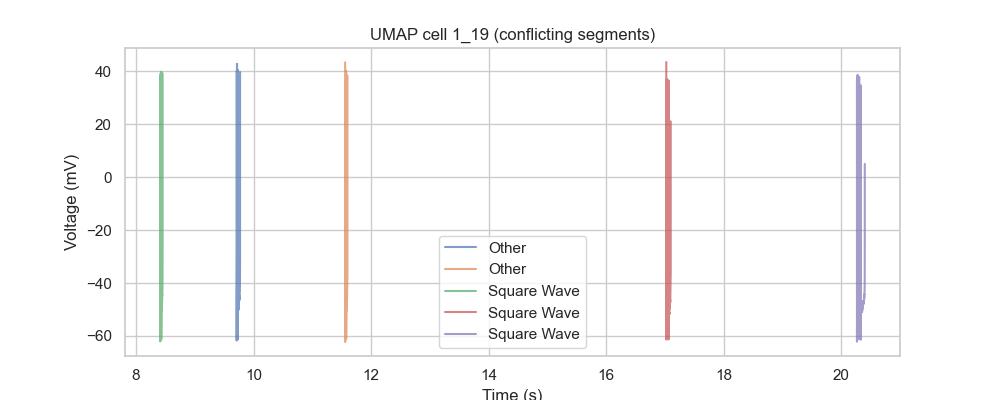

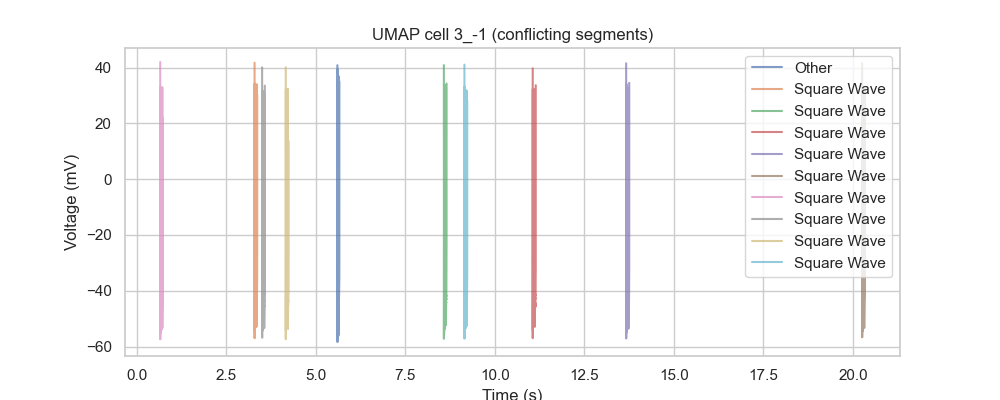

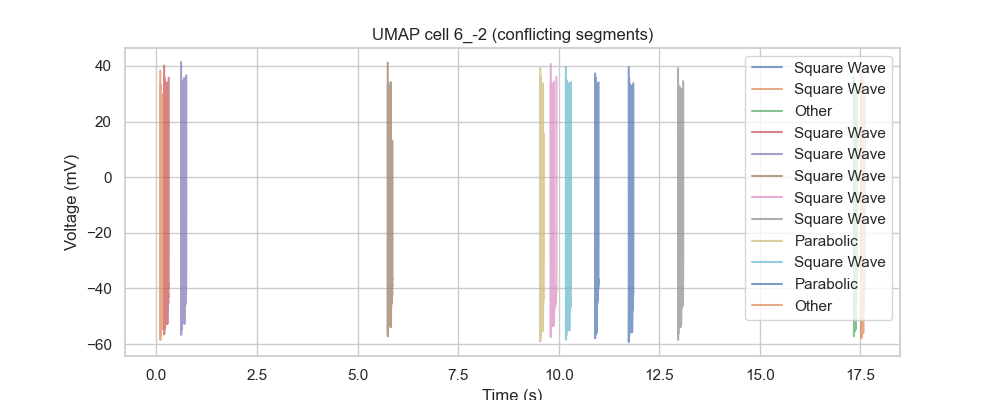

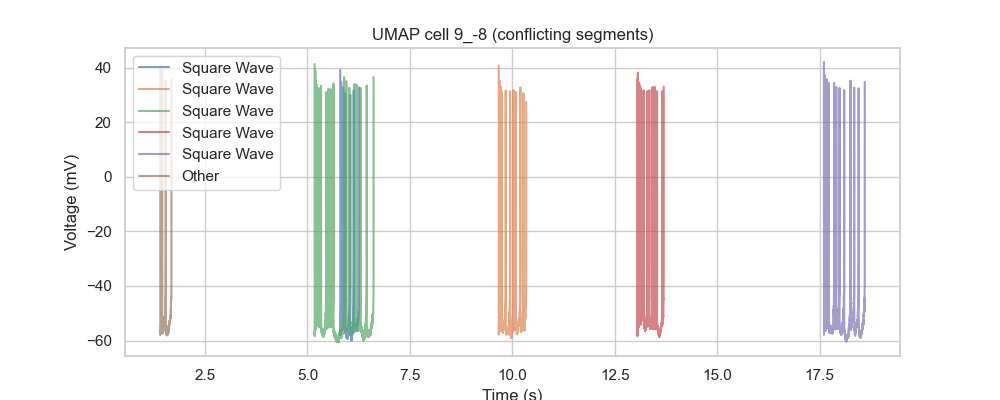

In [7]:
# Libraries
import os
import pyabf
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt

# Configuration
folder_path = "bursting"       # Folder containing ABF files
threshold = -35                # Peak detection threshold (mV)
burst_threshold = 0.3          # Maximum ISI to consider spikes part of a burst (s)
fs = 10000                     # Sampling frequency (Hz)
dt = 1 / fs
min_spikes_in_burst = 4        # Minimum number of spikes to define a burst
bin_size = 0.5                 # UMAP cell size for conflict detection
N = 3                          # Number of conflict pairs to plot

all_segment_metrics = []       # List to store metrics for all segments

# 1. Burst detection and metrics
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)

    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX
        voltage = abf.sweepY

        # Detect spikes using a simple threshold
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs

        # Detect bursts
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)
            current_burst = [spike_times[0]]
            for i in range(1, len(spike_times)):
                if isi[i-1] < burst_threshold:
                    current_burst.append(spike_times[i])
                else:
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))

        # Segment the sweep into bursts and non-bursts
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        if bursts:
            # Add non-burst segments before, between, and after bursts
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            for i in range(len(bursts)-1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            segments.append((time[0], time[-1], "Non-burst"))

        # Classify bursts and compute metrics
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]

                # Compute baseline before and after the burst
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])

                burst_min = np.min(seg_voltage)

                # Simple burst classification based on relative voltage
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"

            burst_types.append(burst_type)

        # Compute segment metrics (voltage stats, derivative stats)
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start
            burst_type = burst_types[j]

            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            if len(seg_voltage) < 2:
                # Handle short segments
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)

                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            # Append all metrics for this segment
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, seg_start, seg_end, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])

# 2. Create dataframe and run UMAP
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type",
    "Segment_Start", "Segment_End", "Duration",
    "Num_Peaks", "Mean_ISI", "Mean", "Std", "Min", "Max",
    "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv",
    "Skewness_Deriv", "Kurtosis_Deriv"
])

# Select numerical columns for UMAP
header = ["Duration", "Num_Peaks", "Mean_ISI",
          "Mean", "Std", "Min", "Max",
          "Skewness", "Kurtosis", "Area",
          "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv",
          "Skewness_Deriv", "Kurtosis_Deriv"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_segments[header])
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)
df_segments["UMAP1"] = embedding[:, 0]
df_segments["UMAP2"] = embedding[:, 1]

df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)
print(f"CSV saved with {len(df_segments)} segments and UMAP coordinates.")

# 3. Detect conflicts in UMAP bursts
df_segments["UMAP_bin"] = (
    (df_segments["UMAP1"] // bin_size).astype(int).astype(str) + "_" +
    (df_segments["UMAP2"] // bin_size).astype(int).astype(str)
)

# Identify bins containing more than one burst type
conflict_bins = df_segments.groupby("UMAP_bin")["Burst_Type"].nunique()
conflict_bins = conflict_bins.loc[lambda x: x > 1].index
conflict_data = df_segments[df_segments["UMAP_bin"].isin(conflict_bins)]
print(f"{len(conflict_data)} segments are in conflict regions.")

# 4. Plot conflicting bursts and its most adjacent bursts for comparison
pairs = []
for cell, group in conflict_data.groupby("UMAP_bin"):
    types = group["Burst_Type"].unique()
    if len(types) > 1:
        for i, row1 in group.iterrows():
            for j, row2 in group.iterrows():
                if i < j and row1["Burst_Type"] != row2["Burst_Type"]:
                    pairs.append((row1, row2))

print(f"{len(pairs)} conflict pairs detected.")

# Plot the first N conflict pairs
for k, (row1, row2) in enumerate(pairs[:N]):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    for ax, row in zip(axs, [row1, row2]):
        file_path = os.path.join(folder_path, row["File_Name"])
        abf = pyabf.ABF(file_path)
        abf.setSweep(int(row["Sweep"]))
        time = abf.sweepX
        voltage = abf.sweepY
        mask = (time >= row["Segment_Start"]) & (time <= row["Segment_End"])
        ax.plot(time[mask], voltage[mask], label=row["Burst_Type"])
        ax.set_title(f"{row['File_Name']} | Sweep {row['Sweep']} | {row['Burst_Type']}")
        ax.legend()
    plt.tight_layout()
    plt.show()

# 5. Overlay all segments in each conflictive bursts area
for cell, group in conflict_data.groupby("UMAP_bin"):
    if len(group["Burst_Type"].unique()) > 1:
        plt.figure(figsize=(10, 4))
        for _, row in group.iterrows():
            file_path = os.path.join(folder_path, row["File_Name"])
            abf = pyabf.ABF(file_path)
            abf.setSweep(int(row["Sweep"]))
            time = abf.sweepX
            voltage = abf.sweepY
            mask = (time >= row["Segment_Start"]) & (time <= row["Segment_End"])
            plt.plot(time[mask], voltage[mask], label=row["Burst_Type"], alpha=0.7)
        plt.title(f"UMAP cell {cell} (conflicting segments)")
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (mV)")
        plt.legend()
        plt.show()
